In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import lightning as L


class CVAE(nn.Module): 
    def __init__(self, in_channels: int, num_classes: int = 10, encoding_dim=32):
        super().__init__()
        self.num_classes = num_classes
        self.encoding_dim = encoding_dim
        
        # Label embedding
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        # Encoder - takes image + label
        self.conv1 = nn.Conv2d(in_channels + 1, 16, kernel_size=3, stride=1, padding=1)  # +1 for label channel
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.act4 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 5 * 5, 256)
        self.act5 = nn.ReLU()
        
        self.mu = nn.Linear(256, encoding_dim)
        self.logvar = nn.Linear(256, encoding_dim)
        
        self.encoder = nn.Sequential(
            self.conv1,
            self.act1,
            self.conv2,
            self.act2,
            self.conv3,
            self.act3,
            self.conv4,
            self.act4,
            self.flatten,
            self.fc1,
            self.act5
        )

        # Decoder - takes latent vector + label embedding
        self.fc_decoder = nn.Linear(encoding_dim + num_classes, 128 * 5 * 5)
                        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, in_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, log_var):
        """
        Applies the reparameterization trick to sample Z.
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x, labels):
        ## 1. Encoding - concatenate label as additional channel
        batch_size = x.shape[0]
        # Create label channel (batch_size, 1, 28, 28) filled with label value
        label_channel = labels.view(batch_size, 1, 1, 1).float() / (self.num_classes - 1)  # Normalize to [0,1]
        label_channel = label_channel.expand(batch_size, 1, x.shape[2], x.shape[3])
        
        # Concatenate image and label channel
        x_with_label = torch.cat([x, label_channel], dim=1)  # Shape: (batch, in_channels+1, 28, 28)
        
        h = self.encoder(x_with_label)  # h has shape (Batch_size, 256)
        mu = self.mu(h)
        log_var = self.logvar(h)  # log_var has shape (Batch_size, encoding_dim)
        z = self.reparameterize(mu, log_var)  # z has shape (Batch_size, encoding_dim)
        
        ## 2. Decoding - concatenate label embedding to latent vector
        label_embed = self.label_embedding(labels)  # Shape: (batch_size, num_classes)
        z_with_label = torch.cat([z, label_embed], dim=1)  # Shape: (batch_size, encoding_dim + num_classes)
        
        h_dec = F.relu(self.fc_decoder(z_with_label))  # h_dec has shape (Batch_size, 128*5*5)
        h_dec = h_dec.view(-1, 128, 5, 5)  # Shape: (Batch_size, 128, 5, 5)
        reconstruction = self.decoder(h_dec)  # reconstruction has shape (Batch_size, in_channels, H, W)
        return reconstruction, mu, log_var

from torchvision.datasets import MNIST
import numpy as np 

def preprocess(x):
    i = np.array(x)
    i = i / 255.0
    i = np.expand_dims(i, axis=0)
    return i

dataset = MNIST("/results/mgazda/MNIST", download=True, transform=preprocess)

model = CVAE(1, num_classes=10, encoding_dim=128).cuda()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
MAX_EPOCH=50
rec_loss = nn.MSELoss()
kl_divergence_weight = 1e-5

def kl_loss_function(mu, log_var):
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return kl_loss
    
for epoch in range(MAX_EPOCH):
    loss_epoch = 0.0
    kl_epoch = 0.0
    rec_epoch = 0.0
    for x, y in dataloader:
        y = y.cuda()
        x = x.float().cuda()
        x_pred, mu, logvar = model(x, y)  # Pass labels to model
        rec_l = rec_loss(x_pred, x)
        kl_l = kl_divergence_weight * kl_loss_function(mu, logvar)
        total_l = rec_l + kl_l
        loss_epoch += total_l.item()
        kl_epoch += kl_l.item()
        rec_epoch += rec_l.item()
        model.zero_grad()    
        total_l.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{MAX_EPOCH}, total_loss: {loss_epoch/len(dataloader)}, kl_loss: {kl_epoch/len(dataloader)}, rec_loss: {rec_epoch/len(dataloader)}")

Epoch 1/50, total_loss: 0.060740491819381716, kl_loss: 0.006251342872326495, rec_loss: 0.05448914884328842
Epoch 2/50, total_loss: 0.03467385333081086, kl_loss: 0.008633176739513875, rec_loss: 0.026040676576892536
Epoch 3/50, total_loss: 0.03014589935640494, kl_loss: 0.008975729066878557, rec_loss: 0.021170170266429582
Epoch 4/50, total_loss: 0.027291091244419415, kl_loss: 0.009003994987656673, rec_loss: 0.018287096286316713
Epoch 5/50, total_loss: 0.02512923535704613, kl_loss: 0.008875321687509615, rec_loss: 0.016253913708031177
Epoch 6/50, total_loss: 0.023510539970795313, kl_loss: 0.008755404041955869, rec_loss: 0.014755135926604272
Epoch 7/50, total_loss: 0.022342043285568554, kl_loss: 0.008669475329418978, rec_loss: 0.013672567978004615
Epoch 8/50, total_loss: 0.021513105976581574, kl_loss: 0.00861023841748635, rec_loss: 0.012902867543697356
Epoch 9/50, total_loss: 0.020883151561021805, kl_loss: 0.008584358405818542, rec_loss: 0.012298793123662471
Epoch 10/50, total_loss: 0.020401

# Lab 12: Conditional VAE

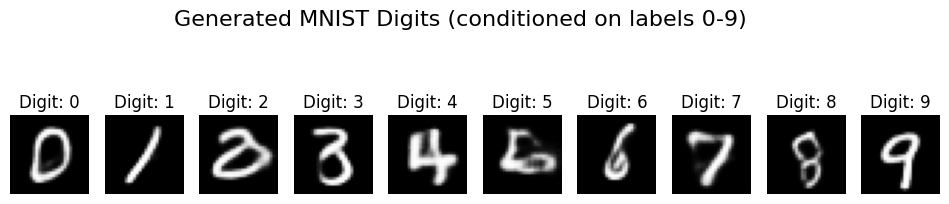

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np

model.eval()

# Generate one sample for each digit (0-9)
N = 10
encoding_dim = model.mu.out_features
z = torch.randn(N, encoding_dim).cuda()  # Random latent vectors
labels = torch.arange(0, N).cuda()  # Labels 0-9

with torch.no_grad():
    label_embed = model.label_embedding(labels)
    z_with_label = torch.cat([z, label_embed], dim=1)
    h_dec = F.relu(model.fc_decoder(z_with_label))
    h_dec = h_dec.view(N, 128, 5, 5)
    generated_images = model.decoder(h_dec)

generated_images = generated_images.cpu().numpy()
plt.figure(figsize=(12, 3))
for i in range(N):
    plt.subplot(1, N, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap='gray')
    plt.title(f"Digit: {i}")
    plt.axis('off')
plt.suptitle('Generated MNIST Digits (conditioned on labels 0-9)', fontsize=16)
plt.savefig('ss.png')

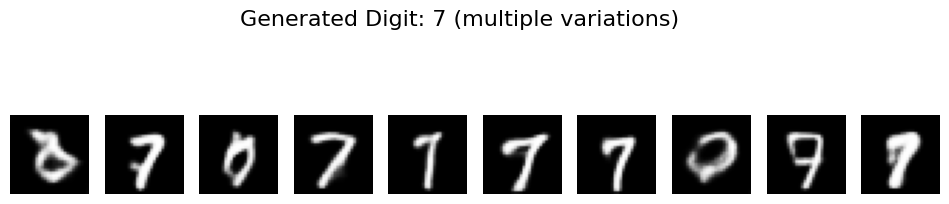

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np

model.eval()

# Generate multiple samples of a specific digit
target_digit = 7  # Change this to generate different digits (0-9)
num_samples = 10

encoding_dim = model.mu.out_features
z = torch.randn(num_samples, encoding_dim).cuda()  # Random latent vectors
labels = torch.full((num_samples,), target_digit, dtype=torch.long).cuda()  # All same digit

with torch.no_grad():
    label_embed = model.label_embedding(labels)
    z_with_label = torch.cat([z, label_embed], dim=1)
    h_dec = F.relu(model.fc_decoder(z_with_label))
    h_dec = h_dec.view(num_samples, 128, 5, 5)
    generated_images = model.decoder(h_dec)

generated_images = generated_images.cpu().numpy()
plt.figure(figsize=(12, 3))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle(f'Generated Digit: {target_digit} (multiple variations)', fontsize=16)
plt.show()

In [4]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import torch
import torch.nn.functional as F
import numpy as np

model.eval()

# --- Settings ---
NUM_SAMPLES = 30        # Total rows (pairs of digits)
STEPS = 20              # Columns (interpolation steps)
ROWS_PER_PAGE = 10      # How many rows to fit on one PDF page
encoding_dim = model.mu.out_features

# --- 1. Generate Data with Label Conditioning ---
# Generate pairs of Start and End vectors
z_start = torch.randn(NUM_SAMPLES, encoding_dim).cuda()
z_end = torch.randn(NUM_SAMPLES, encoding_dim).cuda()

# Random labels for each interpolation
labels = torch.randint(0, 10, (NUM_SAMPLES,)).cuda()

# Create interpolation steps
# alpha shape: (1, STEPS, 1)
alphas = torch.linspace(0, 1, STEPS).cuda().view(1, STEPS, 1)

# Broadcast to shape: (NUM_SAMPLES, STEPS, encoding_dim)
z_start_expanded = z_start.unsqueeze(1)
z_end_expanded = z_end.unsqueeze(1)
z_interp = (1 - alphas) * z_start_expanded + alphas * z_end_expanded

# Flatten to (NUM_SAMPLES * STEPS, encoding_dim) for batch decoding
z_interp_flat = z_interp.view(-1, encoding_dim)

# Repeat labels for all steps
labels_expanded = labels.unsqueeze(1).expand(NUM_SAMPLES, STEPS).contiguous().view(-1)

with torch.no_grad():
    # Add label conditioning
    label_embed = model.label_embedding(labels_expanded)
    z_with_label = torch.cat([z_interp_flat, label_embed], dim=1)
    
    h_dec = F.relu(model.fc_decoder(z_with_label))
    h_dec = h_dec.view(-1, 128, 5, 5)
    generated_images = model.decoder(h_dec)

# Reshape back to (NUM_SAMPLES, STEPS, 28, 28)
images = generated_images.view(NUM_SAMPLES, STEPS, 28, 28).cpu().numpy()
labels_cpu = labels.cpu().numpy()

# --- 2. Create PDF ---
filename = "cvae_interpolations.pdf"

with PdfPages(filename) as pdf:
    # Iterate through chunks (pages)
    for page in range(0, NUM_SAMPLES, ROWS_PER_PAGE):
        fig = plt.figure(figsize=(STEPS, ROWS_PER_PAGE))
        
        # Plot the batch for this page
        for row in range(ROWS_PER_PAGE):
            actual_row_idx = page + row
            if actual_row_idx >= NUM_SAMPLES: break
            
            for col in range(STEPS):
                # Subplot index counts from 1
                ax = plt.subplot(ROWS_PER_PAGE, STEPS, (row * STEPS) + col + 1)
                
                plt.imshow(images[actual_row_idx, col], cmap='gray')
                plt.axis('off')
                
                # Label with digit class
                if col == 0:
                    ax.set_ylabel(f"Digit {labels_cpu[actual_row_idx]}", fontsize=8, rotation=0, labelpad=20)
                if row == 0:
                    if col == 0: ax.set_title("Start", fontsize=8)
                    if col == STEPS - 1: ax.set_title("End", fontsize=8)

        plt.tight_layout(pad=0.5)
        pdf.savefig(fig)  # Save the current page
        plt.close()       # Clear memory

print(f"Successfully saved {NUM_SAMPLES} samples to '{filename}'")

Successfully saved 30 samples to 'cvae_interpolations.pdf'


# Generative Adversarial Networks (GANs)

In [5]:
# Basic GAN Implementation
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(1, 28, 28)):
        super().__init__()
        self.img_shape = img_shape
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()  # Output in [-1, 1]
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self, img_shape=(1, 28, 28)):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.model(img)

In [6]:
# Training Basic GAN
from torchvision.datasets import MNIST
import numpy as np

def preprocess_gan(x):
    """Preprocess for GAN: normalize to [-1, 1]"""
    i = np.array(x)
    i = (i / 255.0) * 2 - 1  # Scale to [-1, 1] for tanh output
    i = np.expand_dims(i, axis=0)
    return i

dataset_gan = MNIST("/results/mgazda/MNIST", download=True, transform=preprocess_gan)
dataloader_gan = torch.utils.data.DataLoader(dataset_gan, batch_size=64, shuffle=True)

# Initialize models
latent_dim = 100
generator = Generator(latent_dim=latent_dim).cuda()
discriminator = Discriminator().cuda()

# Optimizers
lr = 0.0002
betas = (0.5, 0.999)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

criterion = nn.BCELoss()

MAX_EPOCH_GAN = 50

for epoch in range(MAX_EPOCH_GAN):
    g_loss_epoch = 0.0
    d_loss_epoch = 0.0
    
    for real_imgs, _ in dataloader_gan:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.float().cuda()
        
        # Labels
        real_labels = torch.ones(batch_size, 1).cuda()
        fake_labels = torch.zeros(batch_size, 1).cuda()
        
        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Real images
        real_output = discriminator(real_imgs)
        d_loss_real = criterion(real_output, real_labels)
        
        # Fake images
        z = torch.randn(batch_size, latent_dim).cuda()
        fake_imgs = generator(z)
        fake_output = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_G.zero_grad()
        
        # Generate fake images and try to fool discriminator
        fake_output = discriminator(fake_imgs)
        g_loss = criterion(fake_output, real_labels)  # Want D to think fake is real
        
        g_loss.backward()
        optimizer_G.step()
        
        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()
    
    print(f"Epoch {epoch+1}/{MAX_EPOCH_GAN}, D_loss: {d_loss_epoch/len(dataloader_gan):.4f}, G_loss: {g_loss_epoch/len(dataloader_gan):.4f}")

Epoch 1/50, D_loss: 0.5060, G_loss: 1.0852
Epoch 2/50, D_loss: 0.6251, G_loss: 0.8681
Epoch 3/50, D_loss: 0.6375, G_loss: 0.8569
Epoch 4/50, D_loss: 0.6567, G_loss: 0.8041
Epoch 5/50, D_loss: 0.6666, G_loss: 0.7797
Epoch 6/50, D_loss: 0.6723, G_loss: 0.7655
Epoch 7/50, D_loss: 0.6774, G_loss: 0.7537
Epoch 8/50, D_loss: 0.6794, G_loss: 0.7482
Epoch 9/50, D_loss: 0.6801, G_loss: 0.7466
Epoch 10/50, D_loss: 0.6815, G_loss: 0.7454
Epoch 11/50, D_loss: 0.6816, G_loss: 0.7437
Epoch 12/50, D_loss: 0.6828, G_loss: 0.7405
Epoch 13/50, D_loss: 0.6827, G_loss: 0.7393
Epoch 14/50, D_loss: 0.6829, G_loss: 0.7372
Epoch 15/50, D_loss: 0.6834, G_loss: 0.7375
Epoch 16/50, D_loss: 0.6834, G_loss: 0.7379
Epoch 17/50, D_loss: 0.6840, G_loss: 0.7355
Epoch 18/50, D_loss: 0.6833, G_loss: 0.7366
Epoch 19/50, D_loss: 0.6829, G_loss: 0.7392
Epoch 20/50, D_loss: 0.6830, G_loss: 0.7370
Epoch 21/50, D_loss: 0.6823, G_loss: 0.7383
Epoch 22/50, D_loss: 0.6830, G_loss: 0.7382
Epoch 23/50, D_loss: 0.6831, G_loss: 0.73

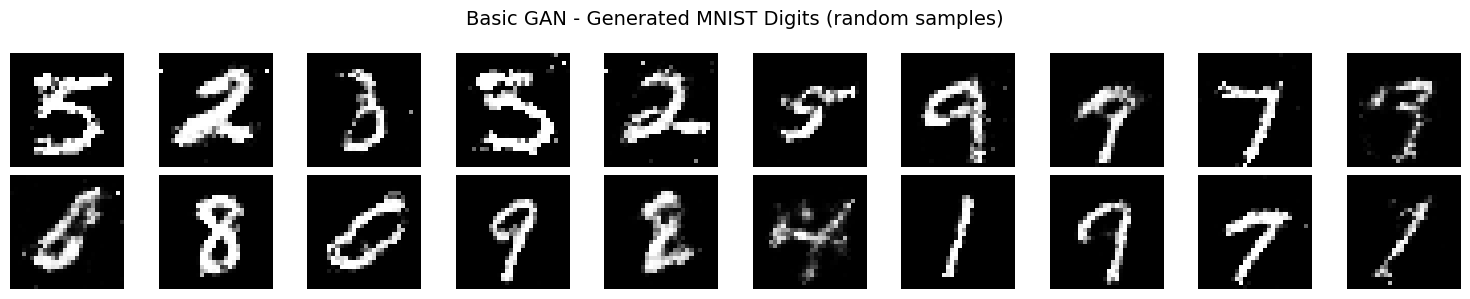

In [7]:
# Visualize Basic GAN Generated Samples
import matplotlib.pyplot as plt

generator.eval()
with torch.no_grad():
    z = torch.randn(20, latent_dim).cuda()
    generated = generator(z).cpu().numpy()

plt.figure(figsize=(15, 3))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    # Rescale from [-1, 1] to [0, 1] for display
    img = (generated[i].squeeze() + 1) / 2
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle('Basic GAN - Generated MNIST Digits (random samples)', fontsize=14)
plt.tight_layout()
plt.show()

## Conditional GAN

In [8]:
# Conditional GAN Implementation
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10, img_shape=(1, 28, 28)):
        super().__init__()
        self.img_shape = img_shape
        self.num_classes = num_classes
        
        # Label embedding
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        # Concatenate noise and label embedding
        label_embed = self.label_embedding(labels)
        gen_input = torch.cat([z, label_embed], dim=1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *self.img_shape)
        return img


class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10, img_shape=(1, 28, 28)):
        super().__init__()
        self.num_classes = num_classes
        
        # Label embedding
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))) + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img, labels):
        # Flatten image and concatenate with label embedding
        img_flat = img.view(img.size(0), -1)
        label_embed = self.label_embedding(labels)
        disc_input = torch.cat([img_flat, label_embed], dim=1)
        return self.model(disc_input)

In [9]:
# Training Conditional GAN
# Initialize models
latent_dim_cgan = 100
cond_generator = ConditionalGenerator(latent_dim=latent_dim_cgan, num_classes=10).cuda()
cond_discriminator = ConditionalDiscriminator(num_classes=10).cuda()

# Optimizers
optimizer_cG = torch.optim.Adam(cond_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_cD = torch.optim.Adam(cond_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion_cgan = nn.BCELoss()

MAX_EPOCH_CGAN = 50

for epoch in range(MAX_EPOCH_CGAN):
    g_loss_epoch = 0.0
    d_loss_epoch = 0.0
    
    for real_imgs, labels in dataloader_gan:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.float().cuda()
        labels = labels.cuda()
        
        # Labels for loss
        real_labels = torch.ones(batch_size, 1).cuda()
        fake_labels = torch.zeros(batch_size, 1).cuda()
        
        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_cD.zero_grad()
        
        # Real images with correct labels
        real_output = cond_discriminator(real_imgs, labels)
        d_loss_real = criterion_cgan(real_output, real_labels)
        
        # Fake images
        z = torch.randn(batch_size, latent_dim_cgan).cuda()
        gen_labels = torch.randint(0, 10, (batch_size,)).cuda()  # Random labels for generation
        fake_imgs = cond_generator(z, gen_labels)
        fake_output = cond_discriminator(fake_imgs.detach(), gen_labels)
        d_loss_fake = criterion_cgan(fake_output, fake_labels)
        
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_cD.step()
        
        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_cG.zero_grad()
        
        # Generate and try to fool discriminator
        fake_output = cond_discriminator(fake_imgs, gen_labels)
        g_loss = criterion_cgan(fake_output, real_labels)
        
        g_loss.backward()
        optimizer_cG.step()
        
        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()
    
    print(f"Epoch {epoch+1}/{MAX_EPOCH_CGAN}, D_loss: {d_loss_epoch/len(dataloader_gan):.4f}, G_loss: {g_loss_epoch/len(dataloader_gan):.4f}")

Epoch 1/50, D_loss: 0.4067, G_loss: 1.8496
Epoch 2/50, D_loss: 0.5238, G_loss: 1.4447
Epoch 3/50, D_loss: 0.6102, G_loss: 0.9718
Epoch 4/50, D_loss: 0.6341, G_loss: 0.8983
Epoch 5/50, D_loss: 0.6517, G_loss: 0.8397
Epoch 6/50, D_loss: 0.6648, G_loss: 0.8006
Epoch 7/50, D_loss: 0.6740, G_loss: 0.7687
Epoch 8/50, D_loss: 0.6772, G_loss: 0.7620
Epoch 9/50, D_loss: 0.6819, G_loss: 0.7467
Epoch 10/50, D_loss: 0.6842, G_loss: 0.7369
Epoch 11/50, D_loss: 0.6865, G_loss: 0.7296
Epoch 12/50, D_loss: 0.6861, G_loss: 0.7290
Epoch 13/50, D_loss: 0.6872, G_loss: 0.7273
Epoch 14/50, D_loss: 0.6883, G_loss: 0.7233
Epoch 15/50, D_loss: 0.6890, G_loss: 0.7183
Epoch 16/50, D_loss: 0.6884, G_loss: 0.7174
Epoch 17/50, D_loss: 0.6890, G_loss: 0.7174
Epoch 18/50, D_loss: 0.6893, G_loss: 0.7161
Epoch 19/50, D_loss: 0.6891, G_loss: 0.7162
Epoch 20/50, D_loss: 0.6899, G_loss: 0.7134
Epoch 21/50, D_loss: 0.6893, G_loss: 0.7150
Epoch 22/50, D_loss: 0.6898, G_loss: 0.7126
Epoch 23/50, D_loss: 0.6897, G_loss: 0.71

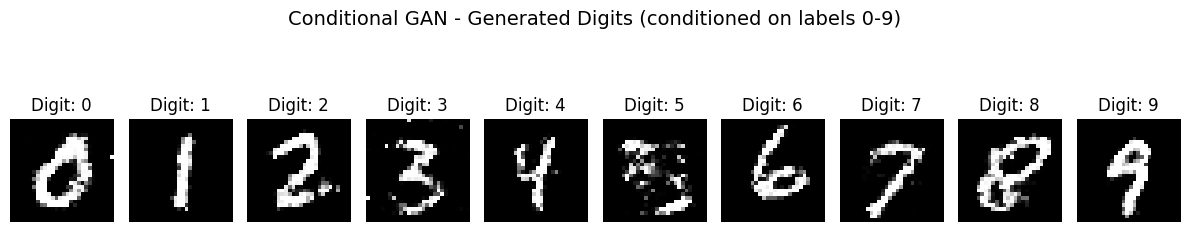

In [10]:
# Visualize Conditional GAN - One sample per digit class
import matplotlib.pyplot as plt

cond_generator.eval()

N = 10
with torch.no_grad():
    z = torch.randn(N, latent_dim_cgan).cuda()
    labels = torch.arange(0, N).cuda()  # Labels 0-9
    generated = cond_generator(z, labels).cpu().numpy()

plt.figure(figsize=(12, 3))
for i in range(N):
    plt.subplot(1, N, i + 1)
    img = (generated[i].squeeze() + 1) / 2  # Rescale to [0, 1]
    plt.imshow(img, cmap='gray')
    plt.title(f"Digit: {i}")
    plt.axis('off')
plt.suptitle('Conditional GAN - Generated Digits (conditioned on labels 0-9)', fontsize=14)
plt.tight_layout()
plt.show()

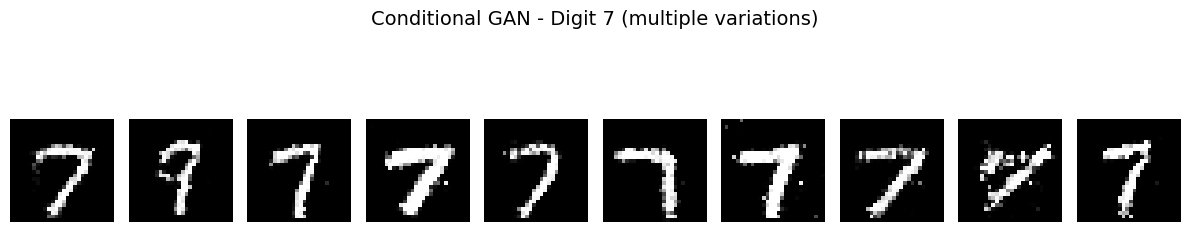

In [11]:
# Visualize Conditional GAN - Multiple variations of a specific digit
target_digit = 7  # Change this to generate different digits (0-9)
num_samples = 10

with torch.no_grad():
    z = torch.randn(num_samples, latent_dim_cgan).cuda()
    labels = torch.full((num_samples,), target_digit, dtype=torch.long).cuda()
    generated = cond_generator(z, labels).cpu().numpy()

plt.figure(figsize=(12, 3))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    img = (generated[i].squeeze() + 1) / 2
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle(f'Conditional GAN - Digit {target_digit} (multiple variations)', fontsize=14)
plt.tight_layout()
plt.show()

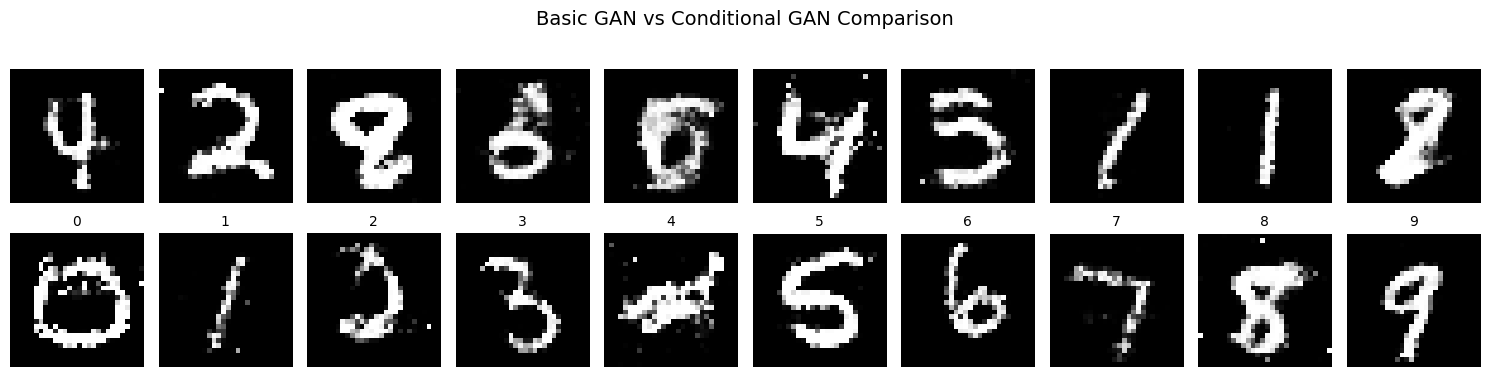

In [12]:
# Comparison: Basic GAN vs Conditional GAN
# Shows the key advantage of cGAN - controllable generation

fig, axes = plt.subplots(2, 10, figsize=(15, 4))

# Row 1: Basic GAN (random, uncontrolled generation)
generator.eval()
with torch.no_grad():
    z = torch.randn(10, latent_dim).cuda()
    basic_gen = generator(z).cpu().numpy()

for i in range(10):
    axes[0, i].imshow((basic_gen[i].squeeze() + 1) / 2, cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Basic GAN\n(random)', fontsize=10)

# Row 2: Conditional GAN (controlled generation, digits 0-9)
cond_generator.eval()
with torch.no_grad():
    z = torch.randn(10, latent_dim_cgan).cuda()
    labels = torch.arange(0, 10).cuda()
    cond_gen = cond_generator(z, labels).cpu().numpy()

for i in range(10):
    axes[1, i].imshow((cond_gen[i].squeeze() + 1) / 2, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'{i}', fontsize=10)
    if i == 0:
        axes[1, i].set_ylabel('cGAN\n(conditioned)', fontsize=10)

plt.suptitle('Basic GAN vs Conditional GAN Comparison', fontsize=14)
plt.tight_layout()
plt.show()

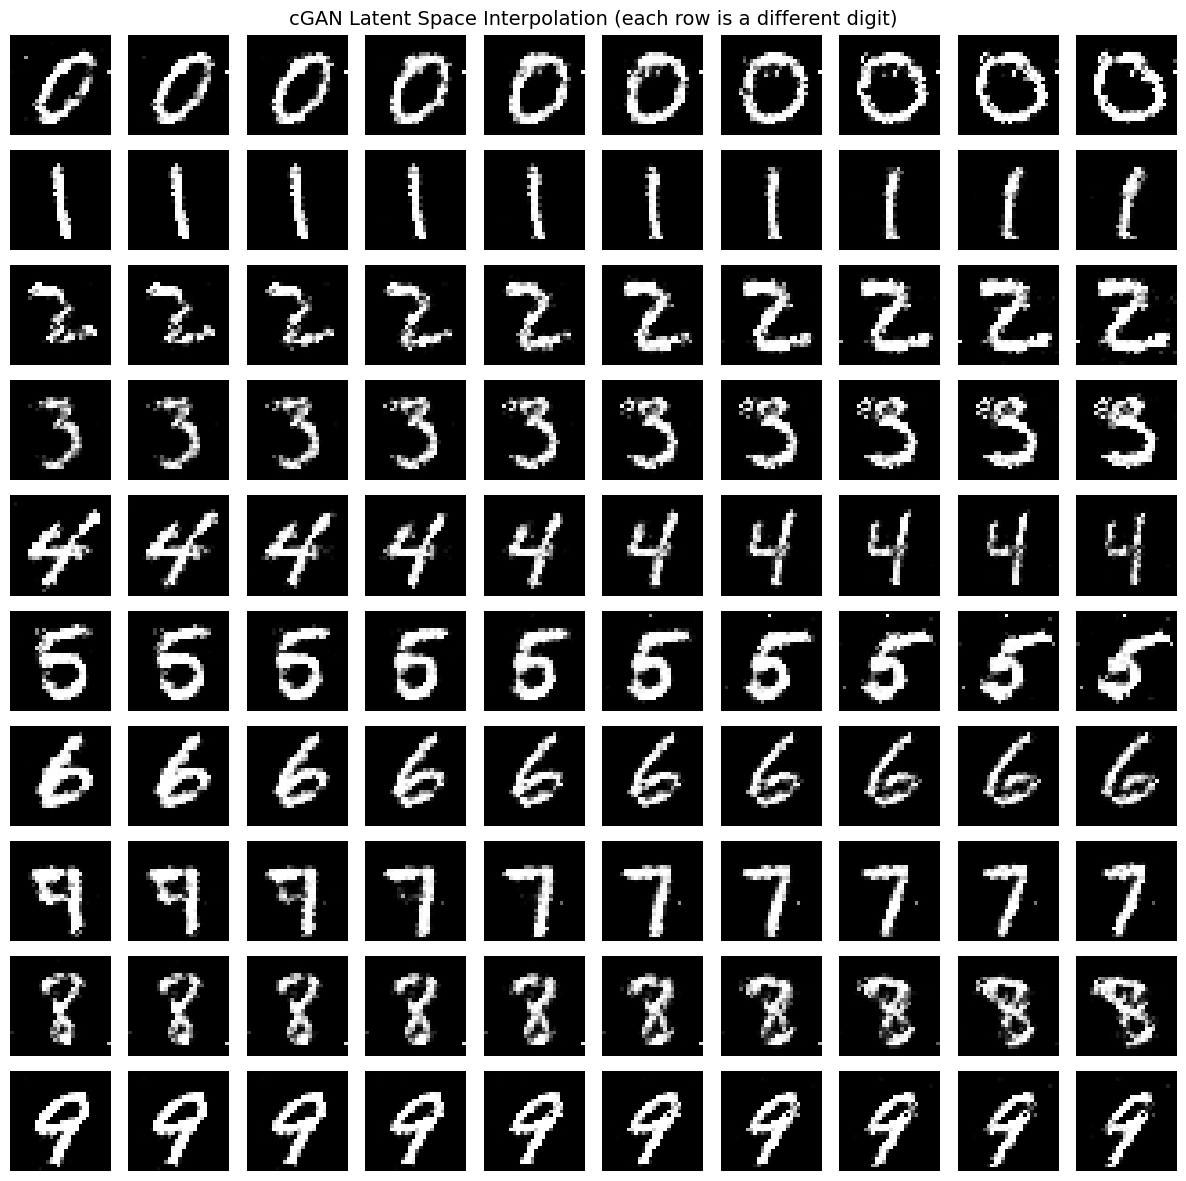

In [13]:
# Conditional GAN - Latent Space Interpolation
# Interpolate between two random points for each digit class

STEPS = 10
NUM_DIGITS = 10

fig, axes = plt.subplots(NUM_DIGITS, STEPS, figsize=(12, 12))

cond_generator.eval()
with torch.no_grad():
    for digit in range(NUM_DIGITS):
        # Generate start and end points in latent space
        z_start = torch.randn(1, latent_dim_cgan).cuda()
        z_end = torch.randn(1, latent_dim_cgan).cuda()
        
        for step in range(STEPS):
            alpha = step / (STEPS - 1)
            z_interp = (1 - alpha) * z_start + alpha * z_end
            label = torch.tensor([digit]).cuda()
            
            generated = cond_generator(z_interp, label).cpu().numpy()
            img = (generated[0].squeeze() + 1) / 2
            
            axes[digit, step].imshow(img, cmap='gray')
            axes[digit, step].axis('off')
            
            if step == 0:
                axes[digit, step].set_ylabel(f'{digit}', fontsize=10, rotation=0, labelpad=15)

plt.suptitle('cGAN Latent Space Interpolation (each row is a different digit)', fontsize=14)
plt.tight_layout()
plt.show()